In [0]:
!nvidia-smi

Здравствуйте, я выбрал задачу:

Перенести одновременно два стиля на одну картинку контента.

В ноутбуке по порядку описал, что менял и какие результаты получил

**Как работает реализованный NST?**

Всего есть 4 картинки: вход, 2 стиля и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная картинка контента.

Для корректной работы установим соответствующие библиотеки

In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary # описание модели и её параметров

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [82]:
!ls images/

autojo.jpg   girl.jpg	  japan.jpg  lisa.jpg  muxa.jpg     sanya.jpg
dancing.jpg  hokusay.jpg  jhon.jpg   munk.jpg  picasso.jpg  vangog.jpg


**Загрузим изображения**

Нам понадобятся картинки двух стилей и контента, так что загрузим их.

Чтобы упростить реализацию, начнем с контента и стилей одного размера. 

Затем мы масштабируем их до требуемых размеров выходного изображения.

In [0]:
imsize = 512  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

#Указываем пути к нашим картинкам

style_img = image_loader("images/munk.jpg")
content_img = image_loader("images/sanya.jpg")
style2_img = image_loader("images/vangog.jpg")
device

device(type='cuda')

Выведем то, что было загружено

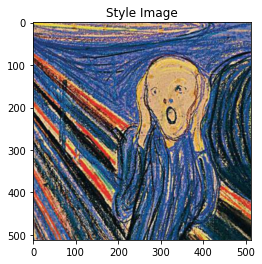

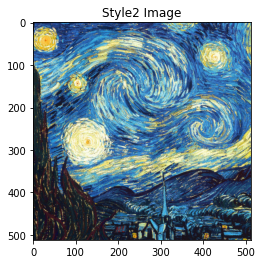

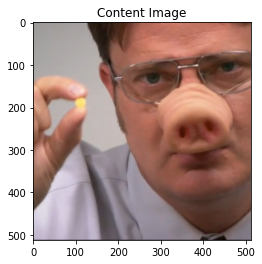

In [12]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style2_img, title='Style2 Image')

plt.figure()
imshow(content_img, title='Content Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_C$ - средняя квадратичная ощибка input'а и target'а

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach() #это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении.

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE


Я решил не менять сам StyleLoss, а добавить его у модели, аргументируя это тем, что этот вариант пришёл быстрее в голову и он оказался рабочим 

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и три функции потерь 

Определим после каких уровней мы будем считать ошибки стилей, а после каких ошибки контента

От себя добавил к стилям ещё 4 уровню, как мне показалось, стало лучше рисовать

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5','conv_6','conv_7','conv_8']

Определим предобученную модель

In [28]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


В данную функцию добавил ещё один стиль, чтобы за один проход на картинку накладывались оба стиля

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,style2_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []
        style2_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
            
            if name in style_layers:
                # add style2 loss:
                target_feature = model(style2_img).detach()
                style2_loss = StyleLoss(target_feature)
                model.add_module("style2_loss_{}".format(i), style2_loss)
                style2_losses.append(style2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses, style2_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [0]:
# 7100 хорошо сходится
# 12100 hokusay-vangog
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style2_img,input_img, num_steps=1550,
                        style_weight=121275,style2_weight=121270, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses, style2_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img,style2_img)
        optimizer = get_input_optimizer(input_img)

        print(model)

        content_losses_graph = []
        style_losses_graph = []
        style2_losses_graph = []

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0
                style2_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                for s2l in style2_losses:
                    style2_score += s2l.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight
                style2_score *= style2_weight

                loss = style_score + content_score + style2_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    style2_losses_graph.append(style2_score.item())
                    style_losses_graph.append(style_score.item())
                    content_losses_graph.append(content_score.item())
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} \nStyle2 Loss: {:4f} \nContent Loss : {:4f}'.format(
                        style_score.item(), style2_score.item(),content_score.item()))
                    print()

                return style_score + content_score + style2_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img, content_losses_graph,style_losses_graph,style2_losses_graph

Так же решил добавить функцию построения графиков лоссов, так проще отслеживать , где лосс сильно подлетает и из картинки получается цветовая каша

In [0]:
def graphicLoss(contentloss,styleloss,style2loss,only_style_loss):
  if only_style_loss:
    plt.plot(range(len(styleloss)), styleloss, label='style-loss')
    plt.plot(range(len(style2loss)), style2loss, label='style2-loss')
    plt.suptitle("Style loss graph")
  else:
    plt.suptitle("Content loss graph")
    plt.plot(range(len(contentloss)), contentloss, label='content-loss')
  plt.legend()
  plt.show()

Пришло время это обучать и смотреть на результат <br>:)

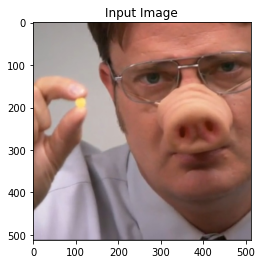

Building the style transfer model..
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (style2_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (style2_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (style2_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (style2_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (styl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 4391.656250 
Style2 Loss: 4600.977051 
Content Loss : 42.375191

run [100]:
Style Loss : 4297.521973 
Style2 Loss: 4259.034180 
Content Loss : 43.364277

run [150]:
Style Loss : 4263.935547 
Style2 Loss: 4257.583984 
Content Loss : 42.981873

run [200]:
Style Loss : 4256.950195 
Style2 Loss: 4257.347168 
Content Loss : 42.477154

run [250]:
Style Loss : 4252.526855 
Style2 Loss: 4258.297852 
Content Loss : 41.881222

run [300]:
Style Loss : 4251.815430 
Style2 Loss: 4256.913574 
Content Loss : 41.303215

run [350]:
Style Loss : 4253.592285 
Style2 Loss: 4253.857910 
Content Loss : 40.784405

run [400]:
Style Loss : 4249.458496 
Style2 Loss: 4257.257324 
Content Loss : 40.348431

run [450]:
Style Loss : 4250.964355 
Style2 Loss: 4255.223633 
Content Loss : 39.949924

run [500]:
Style Loss : 4249.005371 
Style2 Loss: 4256.845703 
Content Loss : 39.533360

run [550]:
Style Loss : 4249.276367 
Style2 Loss: 4256.343262 
Content Loss : 39.183037

run [600]:
Style Loss 

In [40]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output,content_losses_graph,style_losses_graph,style2_losses_graph = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img,style2_img, input_img)

Выведем результат нашего обучения

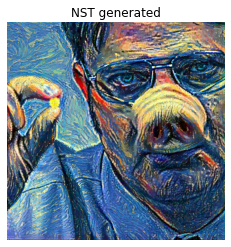

In [41]:
fig = plt.figure()
plt.axis('off')
imshow(output, title='NST generated')
plt.show()

Здесь посмотрим результат и входные картинки, чтобы не листать навверх и смотреть, какие стили были применины

In [0]:
def tensorToImage(tensor):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    return image

# отрисовка
def allPictureInHorizontal(output,style_img,style2_img,content_img):
  fig = plt.figure(figsize=(20,10))
  plt.subplot(2,4,1)
  plt.imshow(tensorToImage(output))
  plt.axis('off')
  plt.title('NST generated')

  plt.subplot(2,4,2)
  plt.imshow(tensorToImage(style_img))
  plt.axis('off')
  plt.title('Style Image')

  plt.subplot(2,4,3)
  plt.imshow(tensorToImage(style2_img))
  plt.axis('off')
  plt.title('Style2 Image')

  plt.subplot(2,4,4)
  plt.imshow(tensorToImage(content_img))
  plt.axis('off')
  plt.title('Content Image')

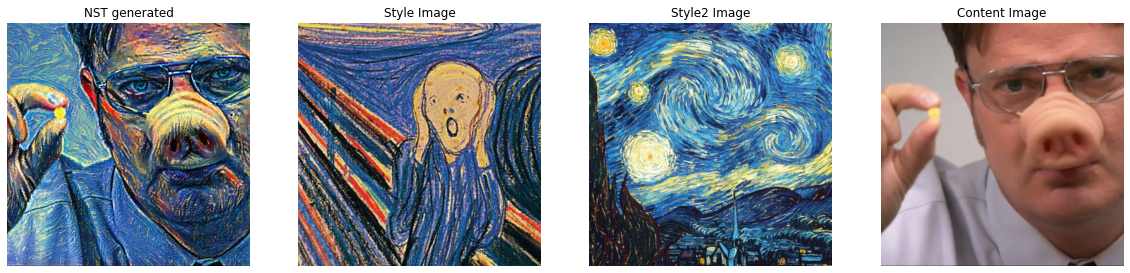

In [52]:
allPictureInHorizontal(output,style_img,style2_img,content_img)

Посмотрим на графикы и поймем, почему результат мог превратиться в кашу цветов

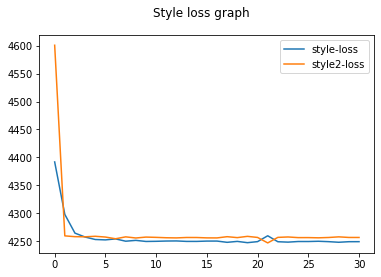

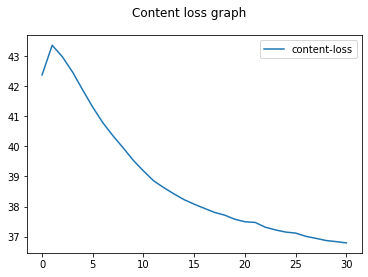

In [85]:
graphicLoss(content_losses_graph,style_losses_graph,style2_losses_graph,True)
graphicLoss(content_losses_graph,style_losses_graph,style2_losses_graph,False)

В данном блоке продемонстрированы мои эксперементы:

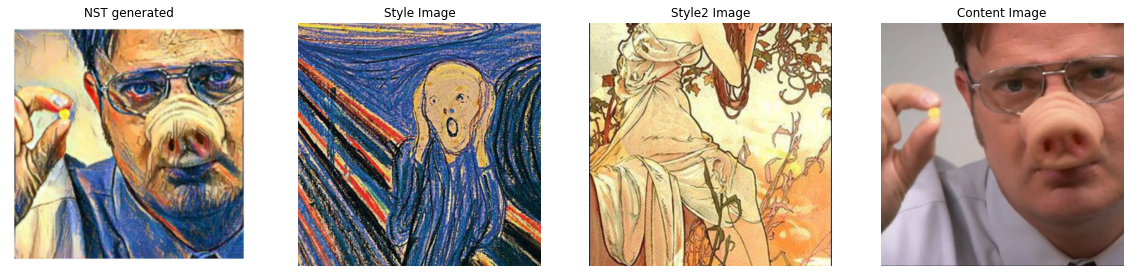

In [57]:
output_ex = image_loader("examples/munk-muxa.png")
style_img_ex = image_loader("images/munk.jpg")
style2_img_ex = image_loader("images/muxa.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

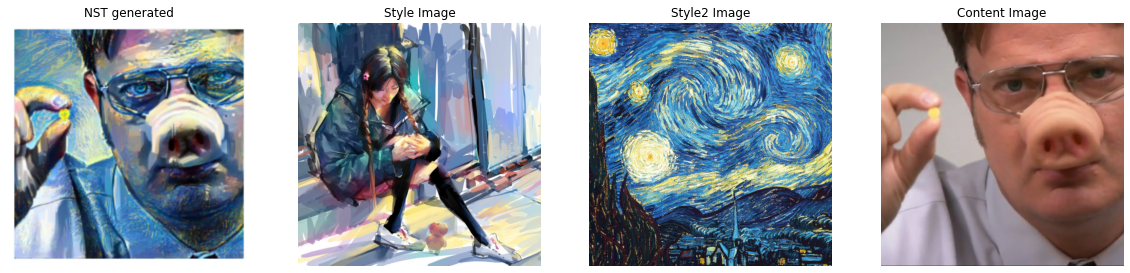

In [77]:
output_ex = image_loader("examples/japan-vangog.png")
style_img_ex = image_loader("images/japan.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

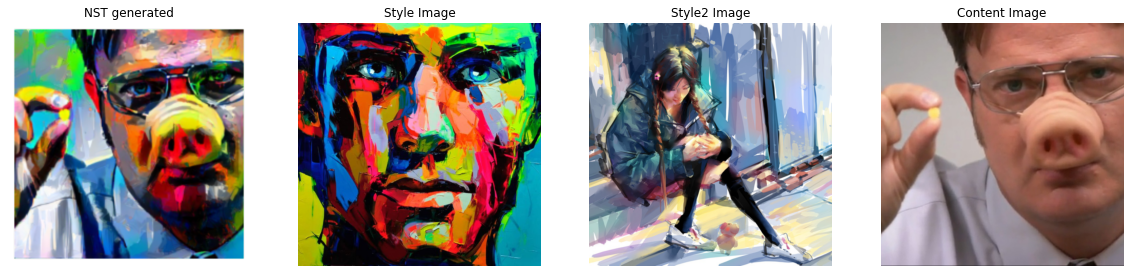

In [70]:
output_ex = image_loader("examples/japan-jhon.png")
style_img_ex = image_loader("images/jhon.jpg")
style2_img_ex = image_loader("images/japan.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

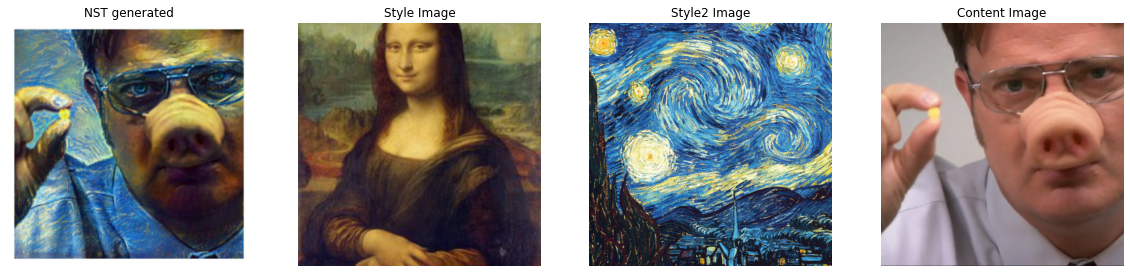

In [72]:
output_ex = image_loader("examples/lisa-vangog.png")
style_img_ex = image_loader("images/lisa.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

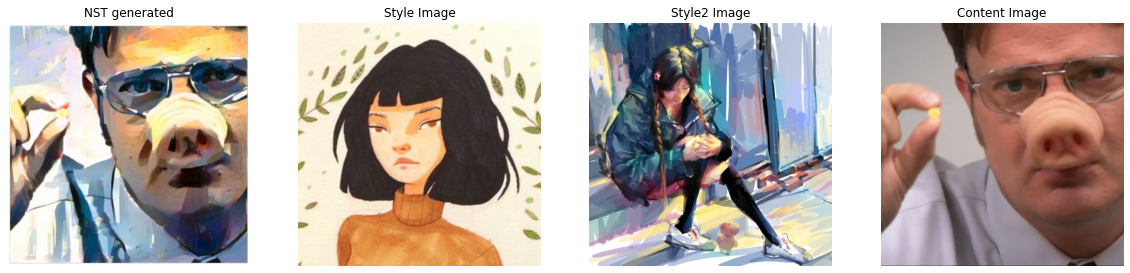

In [79]:
output_ex = image_loader("examples/girl-japan.png")
style_img_ex = image_loader("images/girl.jpg")
style2_img_ex = image_loader("images/japan.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

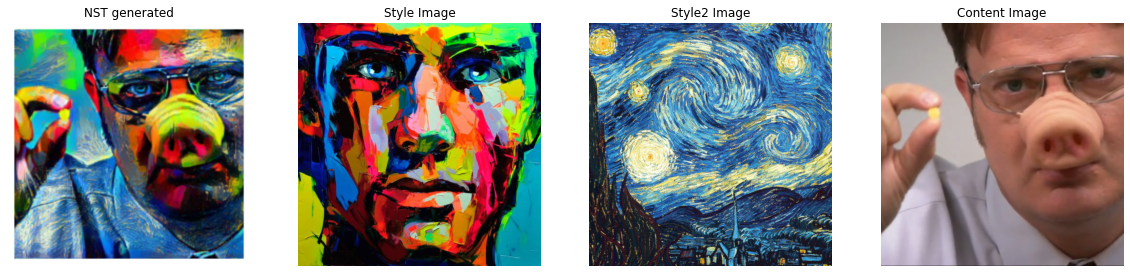

In [74]:
output_ex = image_loader("examples/jhon-vangog.png")
style_img_ex = image_loader("images/jhon.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

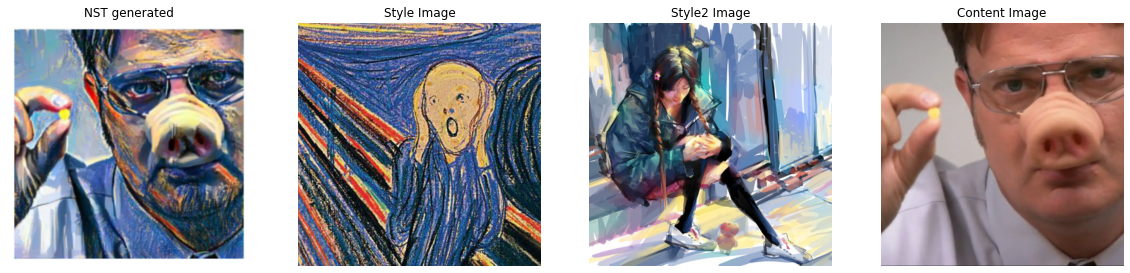

In [66]:
output_ex = image_loader("examples/japanArt-munk.png")
style_img_ex = image_loader("images/munk.jpg")
style2_img_ex = image_loader("images/japan.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

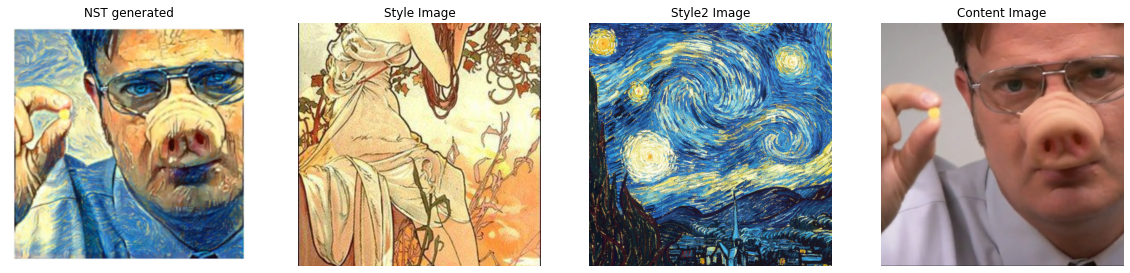

In [60]:
output_ex = image_loader("examples/muxa-vangog.png")
style_img_ex = image_loader("images/muxa.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

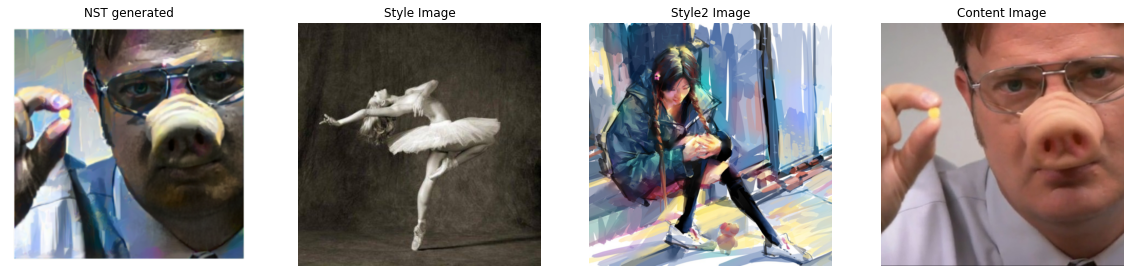

In [84]:
output_ex = image_loader("examples/dancing-japanArt.png")
style_img_ex = image_loader("images/dancing.jpg")
style2_img_ex = image_loader("images/japan.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

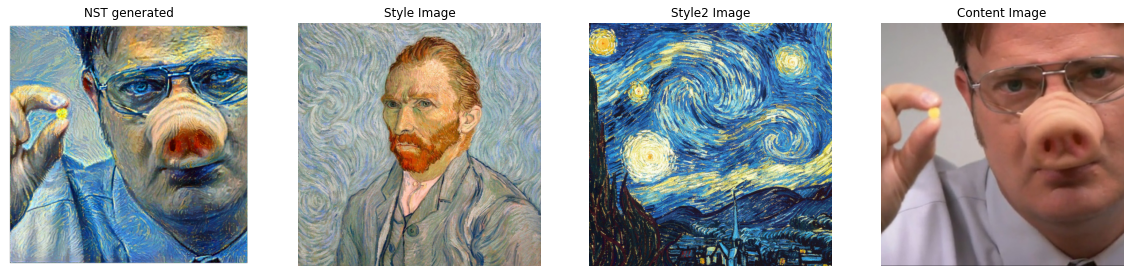

In [62]:
output_ex = image_loader("examples/autojo-vangog.png")
style_img_ex = image_loader("images/autojo.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

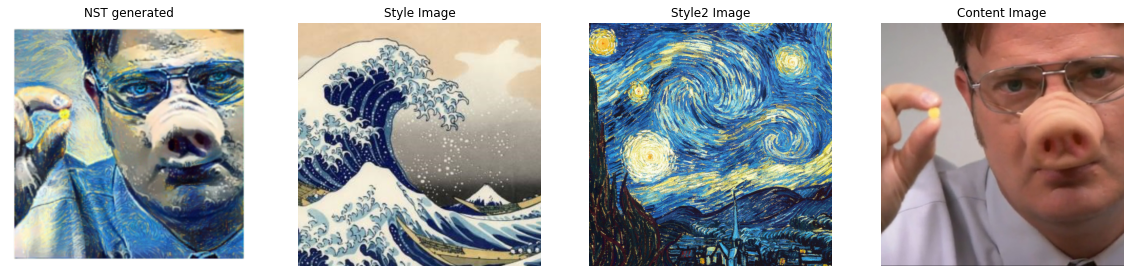

In [65]:
output_ex = image_loader("examples/hokusay-vangog(4650).png")
style_img_ex = image_loader("images/hokusay.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)

Когда дали хорошую карту, решил провести эксперемент и поставил одинаковые веса с кол-вом эпох: 12100<br>
И получилось довольно неплохо, многим людям понравилось

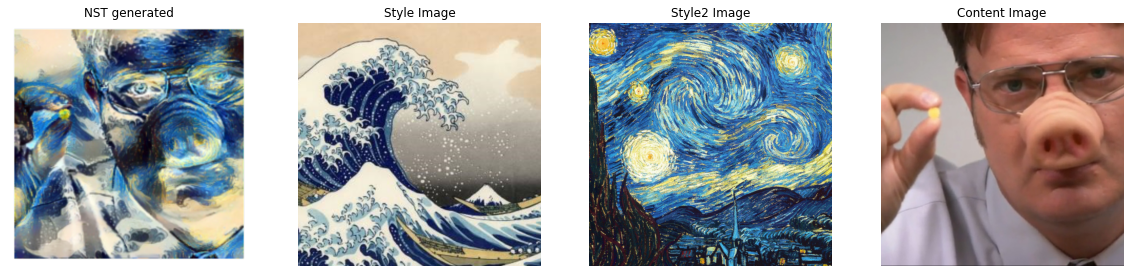

In [64]:
output_ex = image_loader("examples/hokusay-vangog.png")
style_img_ex = image_loader("images/hokusay.jpg")
style2_img_ex = image_loader("images/vangog.jpg")
content_img_ex = image_loader("images/sanya.jpg")

allPictureInHorizontal(output_ex,style_img_ex,style2_img_ex,content_img_ex)